In [1]:
from gapml.vision import Image, Images
from keras.callbacks import LambdaCallback
import cv2

Using TensorFlow backend.


In [2]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [59]:
import keras
from keras.applications.vgg16 import VGG16
from keras import backend as K
from keras.models import Sequential, load_model
from keras.layers import activations, BatchNormalization
from keras.layers.core import Flatten, Dense, Dropout
from keras.optimizers import SGD, Adam
from keras.metrics import categorical_crossentropy
from keras import regularizers
from keras.layers.convolutional import *
from keras.callbacks import ModelCheckpoint

In [4]:
images = Images('chinese/ch_train/',num_proc='all',config=['nostore','gray'],name='chinese')

In [5]:
def convert_size(row):
    if row == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(row, 1024)))
    p = math.pow(1024, i)
    s = round(row / p, 2)
    return "{} {}".format(s, size_name[i])

In [6]:
images[1]

In [7]:
images[0].image

'chinese/ch_train//a440/a440-chuxi_001.png'

In [8]:
dict_list={i:{'dir':img.dir,
              'elapsed':img.elapsed,
              'img_main':img.image.split('/')[-3],
              'img_class':img.image.split('/')[-2],
              'image':img.image.split('/')[-1],
              'label':img.label,
              'name':img.name,
              'rawshape':img.rawshape,
              'ressize':img.ressize,
              'size':img.size,
              'shape':img.shape,
              'time':img.time,
              'type':img.type
             } for i, img in enumerate(images._data)}

# get data frame
df=pd.DataFrame(dict_list).T

# fixed data types
df['size'] = df['size'].astype('int')
df['time'] = df['time'].astype('int')

df['size_max']=df['size']
df['size_min']=df['size']

In [9]:
df2=df.pivot_table(index=['label','type','shape','img_class'],
                   values=['image','size_max','size','size_min','time'],
                   aggfunc={'image':len,'size_max':max,'size':np.mean,'size_min':min,'time':np.mean}
                  )

df2.reset_index(inplace=True)

df2.rename(columns={'size':'size_avg', 'time':'time_avg'}, inplace = True)
df2['size_avg']=df2.apply(lambda row: convert_size(row['size_avg']), axis=1)
df2['size_max']=df2.apply(lambda row: convert_size(row['size_max']), axis=1)
df2['size_min']=df2.apply(lambda row: convert_size(row['size_min']), axis=1)
df2.head()

,label,type,shape,img_class,image,size_avg,size_max,size_min,time_avg
0,0,png,"(65, 79)",a440,236,160.03 B,231.0 B,96.0 B,0
1,1,png,"(65, 79)",a447,195,201.77 B,315.0 B,118.0 B,0
2,2,png,"(65, 79)",a448,193,225.97 B,303.0 B,158.0 B,0
3,3,png,"(65, 79)",a44a,22,232.27 B,282.0 B,197.0 B,0
4,4,png,"(65, 79)",a451,72,181.07 B,281.0 B,92.0 B,0


In [10]:
df2['img_class'].values

array(['a440', 'a447', 'a448', 'a44a', 'a451', 'a453', 'a454', 'a455',
       'a457', 'a45d', 'a45f', 'a464', 'a466', 'a467', 'a46a', 'a46b',
       'a46c', 'a470', 'a473', 'a474', 'a475', 'a476', 'a477', 'a4a3',
       'a4a4', 'a4a7', 'a4bd', 'a4c0', 'a4c6', 'a4ce', 'a4d1', 'a4d2',
       'a4e2', 'a4e5', 'a4e8', 'a4e9', 'a4eb', 'a4ec', 'a4f1', 'a4f4',
       'a4f5', 'a4fb', 'a4fd', 'a540', 'a548', 'a54e', 'a558', 'a55b',
       'a568', 'a569', 'a56b', 'a57e', 'a5a6', 'a5aa', 'a5bb', 'a5bf',
       'a5c1', 'a5c9', 'a5ce', 'a5d0', 'a5d1', 'a5d5', 'a5d8', 'a5db',
       'a5df', 'a5f4', 'a5fd', 'a5fe', 'a650', 'a656', 'a658', 'a65a',
       'a65d', 'a65e', 'a661', 'a662', 'a668', 'a670', 'a67d', 'a67e',
       'a6a8', 'a6b3', 'a6b8', 'a6b9', 'a6ca', 'a6cc', 'a6d1', 'a6d3',
       'a6d5', 'a6d7', 'a6db', 'a6e4', 'a6e6', 'a6e7', 'a6e8', 'a6ec',
       'a6fd', 'a740', 'a751', 'a7da', 'a86b', 'a8a3', 'a8a7', 'a8ad',
       'a8ae', 'a8bd', 'a8c3', 'a8c6', 'a8cf', 'a8d3', 'a8e0', 'a8e2',
      

In [11]:
n,c = df2['label'].values, df2['image'].values

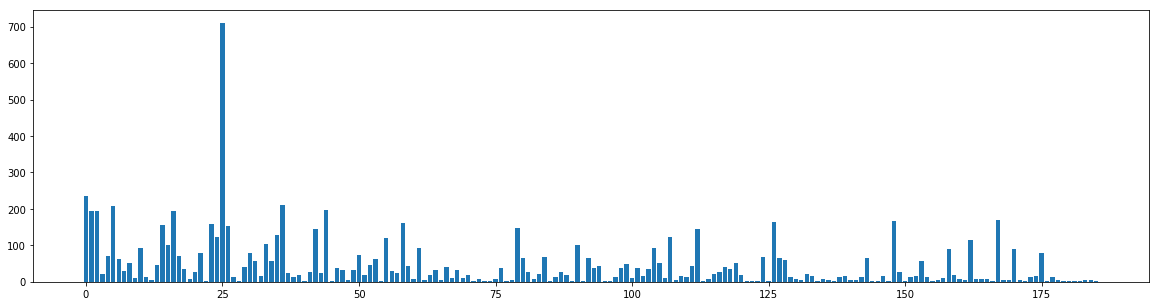

In [12]:
plt.figure(figsize=(20,5))
plt.bar(n,c)
plt.show()

In [13]:
images.split = 0.2
X_train, X_test, Y_train, Y_test = images.split

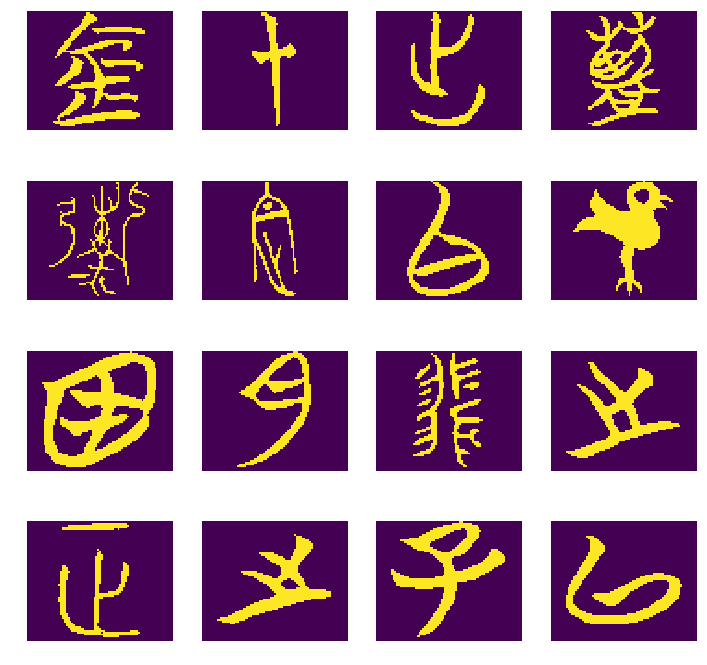

In [14]:
fig=plt.figure(figsize=(12, 12))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    img_show=X_train[i]
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(img_show)
plt.show()

### My Model for Keras (different shape)

In [15]:
X_train,X_test = X_train.reshape(X_train.shape[0],65,79,1),X_test.reshape(X_test.shape[0],65,79,1)

In [16]:
batch_size = 64
num_classes = Y_train.shape[1]
epochs = 20
input_shape = X_train.shape[1:]

_Keras Layers template: [MNIST for Beginners](https://www.kaggle.com/adityaecdrid/mnist-with-keras-for-beginners-99457)_

In [17]:
from keras.callbacks import Callback

In [78]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',kernel_initializer='RandomNormal',input_shape=(65,79,1,)))
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='RandomNormal', kernel_regularizer=regularizers.l2(0.3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.20))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='RandomNormal', kernel_regularizer=regularizers.l2(0.3)))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='RandomNormal', kernel_regularizer=regularizers.l2(0.2)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu',padding='same',kernel_initializer='RandomNormal',kernel_regularizer=regularizers.l2(0.2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

# checkpoint
filepath="weights-improvement-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=True, mode='max')
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(model.layers[0].get_weights()))

callbacks_list = [checkpoint]



model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

In [79]:
model.fit(X_train,Y_train,epochs=3)

Epoch 1/3
6712/6712 [==============================] - 203s 30ms/step - loss: 15.6396 - acc: 0.3232
Epoch 2/3


/Users/ryan/.local/share/virtualenvs/gap-2P59N2hE/lib/python3.6/site-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


6712/6712 [==============================] - 220s 33ms/step - loss: 4.2118 - acc: 0.4470
Epoch 3/3
3040/6712 [============>.................] - ETA: 1:57 - loss: 3.8906 - acc: 0.4984

KeyboardInterrupt: 

In [51]:
model.evaluate(X_test,Y_test)

1679/1679 [==============================] - 20s 12ms/step


[3.2796691266321725, 0.6700416917315262]

In [43]:
prediction_set = Images('chinese/ch_test/', config=['nostore','gray'])
final_images = np.array([im._imgdata.reshape(65,79,1) for im in prediction_set._data[:]])
final_labels = np.array([im.name for im in prediction_set])
pred = model.predict(final_images)

In [44]:
actual_labels = df2['img_class'].values
actual_label = [prediction_set[i].name for i in range(len(prediction_set))]
pred_label = [final_labels[p.argmax()] for p in pred]

In [48]:
v = 0
for i in range(20):
    if actual_label[i] == pred_label[i]:
        v+=1
        print('{}: CORRECT!'.format(i))
    else:
        print('{}: WRONG!'.format(i))
# print(v,v/200)

0: CORRECT!
1: WRONG!
2: WRONG!
3: CORRECT!
4: WRONG!
5: WRONG!
6: WRONG!
7: WRONG!
8: WRONG!
9: WRONG!
10: WRONG!
11: WRONG!
12: WRONG!
13: WRONG!
14: WRONG!
15: WRONG!
16: WRONG!
17: WRONG!
18: WRONG!
19: WRONG!
20: WRONG!
21: WRONG!
22: WRONG!
23: WRONG!
24: WRONG!
25: WRONG!
26: WRONG!
27: WRONG!
28: WRONG!
29: WRONG!
30: WRONG!
31: WRONG!
32: WRONG!
33: WRONG!
34: WRONG!
35: WRONG!
36: WRONG!
37: WRONG!
38: WRONG!
39: WRONG!
40: WRONG!
41: WRONG!
42: WRONG!
43: WRONG!
44: WRONG!
45: WRONG!
46: WRONG!
47: WRONG!
48: WRONG!
49: WRONG!
50: WRONG!
51: WRONG!
52: CORRECT!
53: WRONG!
54: WRONG!
55: WRONG!
56: WRONG!
57: WRONG!
58: WRONG!
59: WRONG!
60: WRONG!
61: WRONG!
62: WRONG!
63: WRONG!
64: WRONG!
65: WRONG!
66: WRONG!
67: WRONG!
68: WRONG!
69: WRONG!
70: WRONG!
71: WRONG!
72: WRONG!
73: WRONG!
74: WRONG!
75: WRONG!
76: WRONG!
77: WRONG!
78: WRONG!
79: WRONG!
80: WRONG!
81: WRONG!
82: WRONG!
83: WRONG!
84: WRONG!
85: WRONG!
86: WRONG!
87: WRONG!
88: WRONG!
89: WRONG!
90: WRONG!
91:

In [49]:
im=Image('chinese/19981.gif',config=['resize=(65,79)','gray'])
im = im.data.reshape(65,79,1)
im = np.expand_dims(im,axis=0)
pred = model.predict(im).argmax()
actual_labels[pred]

'a6e6'

In [50]:
im=Image('chinese/a4a3-real.jpg',config=['resize=(65,79)','gray'])
im = im.data.reshape(65,79,1)
im = np.expand_dims(im,axis=0)
pred = model.predict(im).argmax()
actual_labels[pred]

'a4fd'